In [1]:
%matplotlib inline

import sys
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_laplace
from skimage.feature.peak import peak_local_max

from math import sqrt, hypot, log, pi

import itertools as itt

from skimage.filters import threshold_otsu, threshold_local

In [2]:
# loading tiff stack
stack_0 = sitk.ReadImage('../../../sample_data/cell_detection_0.tiff')
stack_0 = sitk.GetArrayFromImage(stack_0)
image_0 = stack_0 * np.float32(255.0 / stack_0.max())
# img_0 = stack_0 * np.uint16(255 / stack_0.max())
print('shape:', image_0.shape)
print('max:', image_0.max())
print('min:', image_0.min())

shape: (100, 500, 500)
max: 255.0
min: 2.00654


In [3]:
# params
min_sigma = 1
max_sigma = 50
num_sigma = 10
threshold = 0.2
overlap = 0.5
print_level = True
# ===

sigma_list = np.linspace(min_sigma, max_sigma, num_sigma)


# if log_scale:
#     start, stop = log(min_sigma, 10), log(max_sigma, 10)
#     sigma_list = np.logspace(start, stop, num_sigma)
# else:
#     sigma_list = np.linspace(min_sigma, max_sigma, num_sigma)

In [5]:
image = np.copy(image_0)  

# computing gaussian laplace
# s**2 provides scale invariance
gl_images = [-gaussian_laplace(image, s) * s ** 2 for s in sigma_list]
gl_scale_space = np.array(gl_images)
# image_cube = np.dstack(gl_images)

In [6]:
print(gl_scale_space.shape)

(10, 100, 500, 500)


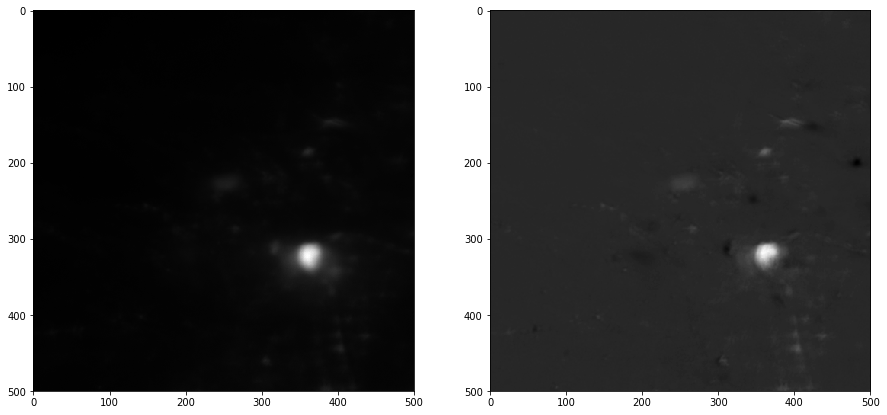

In [7]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.imshow(image[50,:,:], cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.imshow(gl_scale_space[0][50,:,:], cmap=plt.cm.gray)

### Local Maxima 2

In [8]:
gl_thresh = threshold_otsu(gl_scale_space)
print(gl_thresh)

1.22493210062


In [9]:
local_maxima_2 = peak_local_max(gl_scale_space, threshold_abs=gl_thresh,
                                min_distance=10,
#                               footprint=np.ones((10, 10, 10, 10)),
                              threshold_rel=0.0,
                              exclude_border=False)
lm2 = local_maxima_2.astype(np.float64)
# Convert the last index to its corresponding scale value
lm2[:, 0] = sigma_list[local_maxima_2[:, 0]]
local_maxima_2 = lm2

print(local_maxima_2.shape)

(800, 4)


In [10]:
print(local_maxima_2)

[[  39.11111111    0.          172.          499.        ]
 [  33.66666667   99.          499.          200.        ]
 [  33.66666667   99.          424.            0.        ]
 ..., 
 [   1.            0.          190.          350.        ]
 [   1.            0.           65.          363.        ]
 [   1.            0.           64.          350.        ]]


In [11]:
col_permutation = [1,2,3,0]
# perm = np.argsort(col_permutation)
local_maxima_2 = local_maxima_2[:,col_permutation]
print(local_maxima_2)

[[   0.          172.          499.           39.11111111]
 [  99.          499.          200.           33.66666667]
 [  99.          424.            0.           33.66666667]
 ..., 
 [   0.          190.          350.            1.        ]
 [   0.           65.          363.            1.        ]
 [   0.           64.          350.            1.        ]]


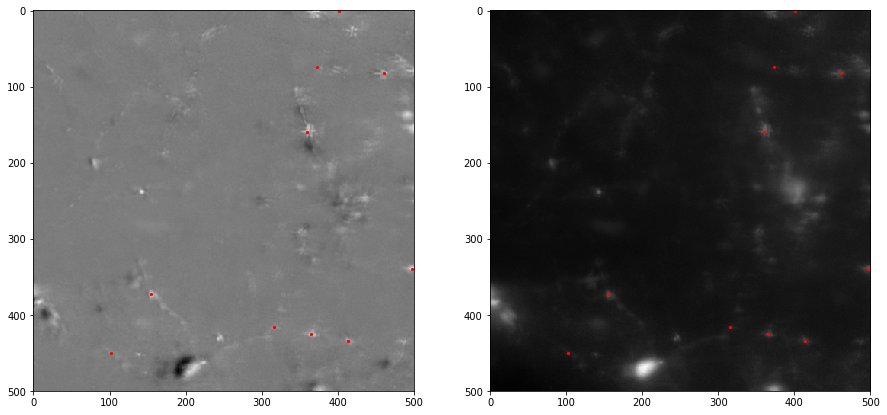

In [12]:
z = 90
sl = local_maxima_2[local_maxima_2[:,0] == z]
# print(sl)

plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.scatter(sl[:,2], sl[:,1], s=5, color='red')
plt.imshow(gl_scale_space[0][z,:,:], cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.scatter(sl[:,2], sl[:,1], s=5, color='red')
plt.imshow(image[z,:,:], cmap=plt.cm.gray)

## Pruning

In [13]:
def _prune_blobs(b_arr, overlap):
    # iterating again might eliminate more blobs, but one iteration suffices
    # for most cases
    blobs_array = np.copy(b_arr)
    
    for blob1, blob2 in itt.combinations(blobs_array, 2):
        if _blob_overlap(blob1, blob2) > overlap:
            if blob1[2] > blob2[2]:
                blob2[2] = -1
            else:
                blob1[2] = -1

    # return blobs_array[blobs_array[:, 2] > 0]
    return np.array([b for b in blobs_array if b[2] > 0])

In [14]:
def _blob_overlap(blob1, blob2):
    root = sqrt(3)

    # extent of the blob is given by sqrt(2)*scale
    r1 = blob1[3] * root
    r2 = blob2[3] * root

    d = hypot_3d(blob1[0] - blob2[0], blob1[1] - blob2[1], blob1[2] - blob2[2])

    if d > r1 + r2:
        return 0

    # one blob is inside the other, the smaller blob must die
    if d <= abs(r1 - r2):
        return 1

    ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
    ratio1 = np.clip(ratio1, -1, 1)
    acos1 = np.arccos(ratio1)

    ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
    ratio2 = np.clip(ratio2, -1, 1)
    acos2 = np.arccos(ratio2)

    a = -d + r2 + r1
    b = d - r2 + r1
    c = d + r2 - r1
    d = d + r2 + r1
    area = r1 ** 2 * acos1 + r2 ** 2 * acos2 - 0.5 * sqrt(abs(a * b * c * d))

    return area / (pi * (min(r1, r2) ** 2))

In [15]:
def hypot_3d(x, y, z):
    return sqrt(x*x + y*y + z*z)

In [16]:
output = _prune_blobs(local_maxima_2, overlap)

In [17]:
print(output.shape)
print(output)

(778, 4)
[[   0.          172.          499.           39.11111111]
 [  99.          466.          336.            6.44444444]
 [  99.           55.          401.            6.44444444]
 ..., 
 [   0.          190.          350.            1.        ]
 [   0.           65.          363.            1.        ]
 [   0.           64.          350.            1.        ]]


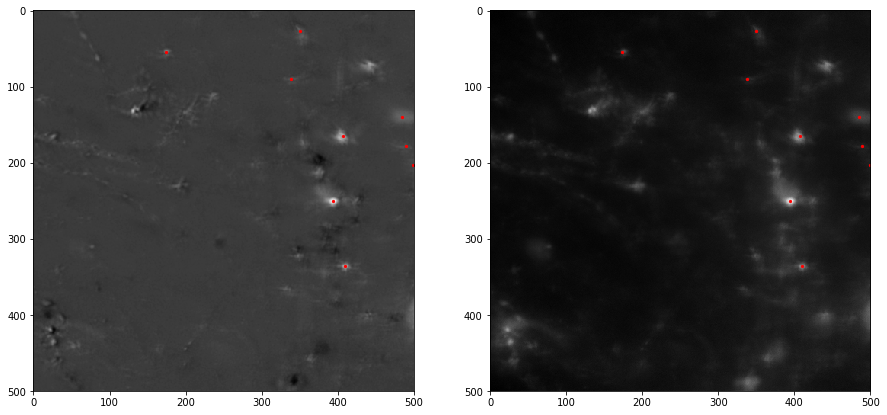

In [19]:
z = 79
sl_0 = output[output[:,0] == z]
# print(sl)

plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.scatter(sl_0[:,2], sl_0[:,1], s=5, color='red')
plt.imshow(gl_scale_space[0][z,:,:], cmap=plt.cm.gray)

plt.subplot(1,2,2)
plt.scatter(sl_0[:,2], sl_0[:,1], s=5, color='red')
plt.imshow(image[z,:,:], cmap=plt.cm.gray)